<h2>Creazione modello ARIMA province complete di tutti i comuni

Le province in questione sono le province di: <b>Piacenza</b>, <b>Ravenna</b>, <b>Gorizia</b>, <b>Trieste</b>, <b>Pordenone</b>, <b>Sondrio</b>, <b>Ragusa</b> e <b>Rovigo</b>.
    </p>

In [1]:
import pandas as pd
df = pd.read_csv('../csv/serie_storica_8province.csv')
df.head()

,DATA,TOTALE
0,2015-01-01,109
1,2015-01-02,104
2,2015-01-03,85
3,2015-01-04,80
4,2015-01-05,100


In [2]:
df['DATA'] = pd.to_datetime(df['DATA'])

<h2>Creazione serie storica

In [3]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-01,109
2015-01-02,104
2015-01-03,85
2015-01-04,80
2015-01-05,100


In [4]:
ts = df.TOTALE
ts.head()

DATA
2015-01-01    109
2015-01-02    104
2015-01-03     85
2015-01-04     80
2015-01-05    100
Name: TOTALE, dtype: int64

<h3>Visualizzazione dei decessi giornalieri delle 8 province dal 2015 al 30 giugno 2020 </h3>

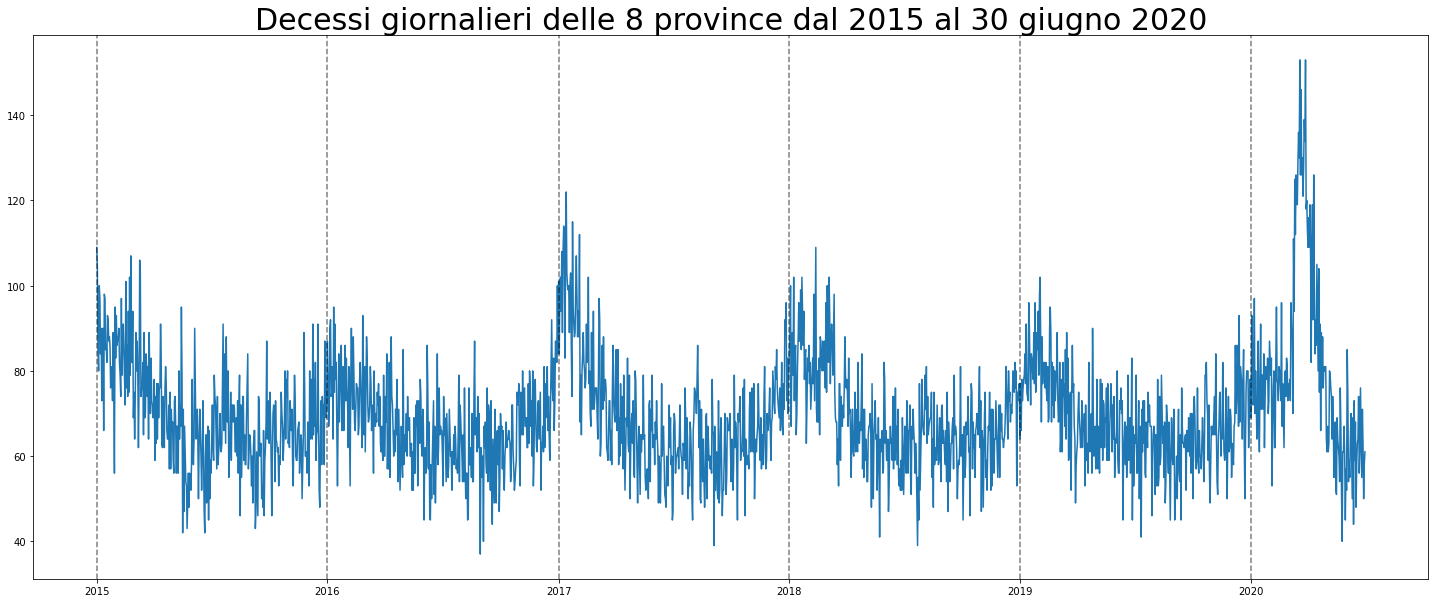

In [5]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.title('Decessi giornalieri delle 8 province dal 2015 al 30 giugno 2020', size=30)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2> Decomposizione della serie </h2>

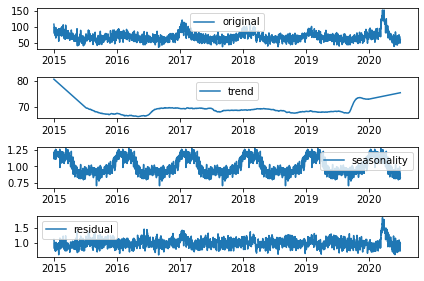

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2> Test di stazionarietà

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")
        

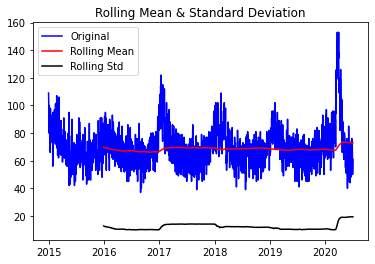

Results of Dickey-Fuller Test:
Test Statistic                  -22.445272
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2007.000000
Critical Value (1%)              -3.433612
Critical Value (5%)              -2.862981
Critical Value (10%)             -2.567537
dtype: float64
X is stationary


In [8]:
test_stationarity(ts)

<h2> Grafici di Autocorrelazione e Autocorrelazione Parziale

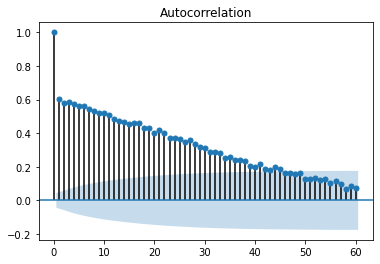

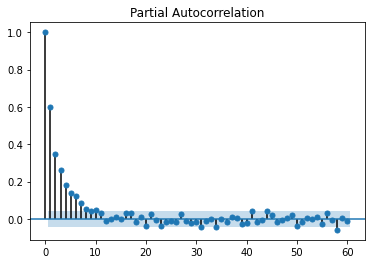

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =60)
plot_pacf(ts, lags =60)
plt.show()

<h2>Suddivisione della serie storica in train e test

Per poter costruire un modello predittivo è necessario suddividere la <b>serie storica </b> in `train` e `test`. 
<br />
La parte di `train`, che va dal <b>1 gennaio 2015</b> al <b>31 ottobre 2019</b>, sarà impiegata per l'allenamento del modello.
<br />
La parte di `test`, che va dal <b>1 novembre 2019</b> al <b>31 dicembre 2019</b>, sarà impiegata invece per testare la precisione di predizione del modello creato, andando a confrontare la predizione ottenuta con i valori originali della parte `test`.

In [10]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

#TEST: dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]


<h1> CREAZIONE DEL MODELLO </h1>

In [11]:
from statsmodels.tsa.arima_model import ARIMA
p = 18
q = 3
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequ

                              ARMA Model Results                              
Dep. Variable:                 TOTALE   No. Observations:                 1765
Model:                    ARMA(18, 3)   Log Likelihood               -6409.752
Method:                       css-mle   S.D. of innovations              9.123
Date:                Wed, 18 Nov 2020   AIC                          12865.505
Time:                        15:10:20   BIC                          12991.451
Sample:                    01-01-2015   HQIC                         12912.042
                         - 10-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            68.4759      0.146    469.235      0.000      68.190      68.762
ar.L1.TOTALE      0.9373      0.067     13.929      0.000       0.805       1.069
ar.L2.TOTALE      0.9690      0.034     

<h3> Verifico che i residui del modello siano stazionari </h3>

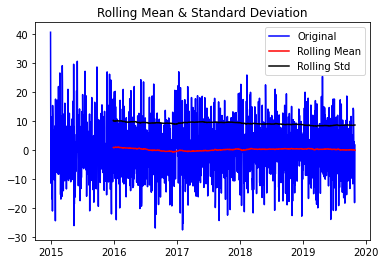

Results of Dickey-Fuller Test:
Test Statistic                  -42.279895
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [12]:
residuals = model_fit.resid
test_stationarity(residuals)

<h3> Confronto dei valori del Train Set con i valori fittati del modello </h3>

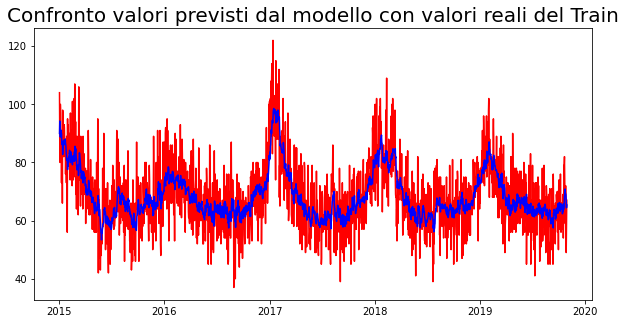

In [13]:
plt.figure(figsize=(10,5))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

<h3> Intervallo di Confidenza del modello </h3>

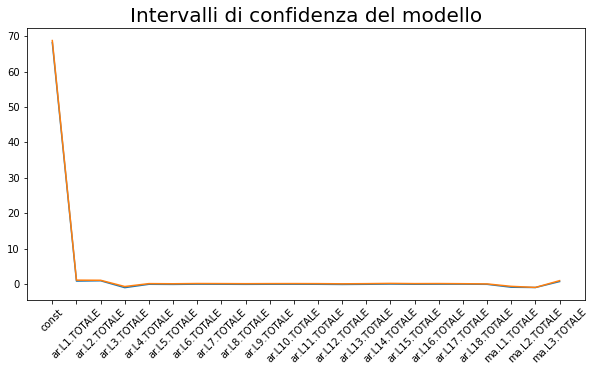

In [14]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h2>Predizione del modello sul test

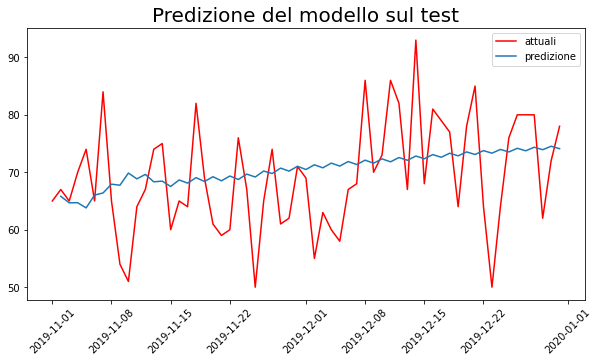

In [15]:
pred_start = test.index[0]
pred_end = test.index[-1]


predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(10,5))
plt.title('Predizione del modello sul test', size=20)
plt.plot(test, color='red', label='attuali')
plt.plot(predictions_test.iloc[1:], label='predizione' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

<h3> Calcolo RMSE </h3>

In [16]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.2150428158805777


<h1> Predizione Totale </h1>

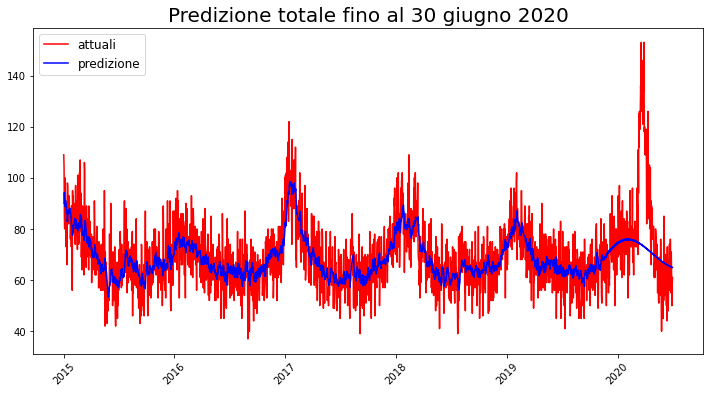

In [21]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Predizione totale fino al 30 giugno 2020', size=20)
plt.plot(ts, color='red', label='attuali')
plt.plot(predictions_tot.iloc[1:], label='predizione', color='blue')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

<h3> Calcolo della differenza tra i valori della previsione e i valori osservati </h3>

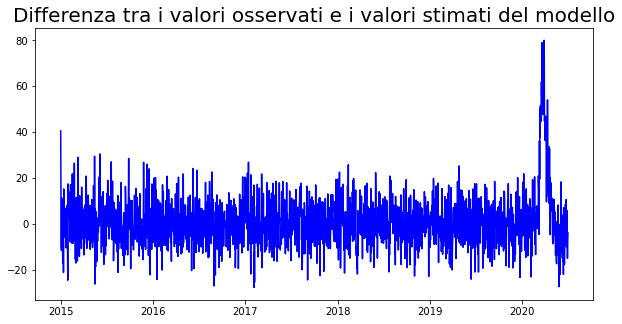

In [18]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot, color='blue') 
plt.show()

In [19]:
diff_predictions_tot['24-02-2020':].sum()

1641.7906798024128

In [20]:
predictions_tot.to_csv('../csv/predictions_daily_ARIMA_8province.csv')